<a href="https://colab.research.google.com/github/EdenHaney/misc/blob/master/lab1_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import timeit
import imageio
from enum import Enum, auto

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, Image

### 1) MDP System

The state space has L x W x H which is 768 number of states.

The action space has 7 possible actions.

In [0]:
class state:
  #lattice point (x, y) : 0 ≤ x < L, 0 ≤ y < W
  _L = 8
  _W = 8
  #headings/orientation
  _H = 12 

  def __init__(self, *args, **kwargs):
    if args:
      if isinstance(args[0], list): 
        if len(args[0]) == 3:
          self.s = args[0]
        else :
          raise ValueError("Wrong number of state inputs")
      if isinstance(args[0], int):
        self.index = args[0]
    elif kwargs:
      self.s = [kwargs['x'], kwargs['y'], kwargs['h']]
    else:
      raise ValueError("Please enter valid inputs")

  @property
  def s(self):
    return self._s
  
  @s.setter
  def s(self, new_s):
    if new_s[0] < 0 or new_s[0] >= self._L:
      raise ValueError(f"x = {new_s[0]}, Not in range")
    if new_s[1] < 0 or new_s[1] >= self._W:
      raise ValueError(f"y = {new_s[1]}, Not in range")
    if new_s[2] < 0 or new_s[2] >= self._H:
      raise ValueError(f"h = {new_s[2]}, Not in range")
    self._s = np.asarray(new_s)
    return

  @property
  def index(self):
    return np.sum(self._s * np.asarray([self._H, self._H*self._W, 1]))

  @index.setter
  def index(self, index):
    vec = [(index // self._H) % self._W, index // (self._H*self._W), index % self._H]
    self.s = vec
    return
  
  def __str__(self):
    return f'x: {self._s[0]}, y: {self._s[1]}, z: {self._s[2]}'
  
  def __repr__(self):
    return f'x: {self._s[0]}, y: {self._s[1]}, z: {self._s[2]}'

  def move(self, vec):
    x = min(max(self._s[0] + vec[0], 0), self._L-1)
    y = min(max(self._s[1] + vec[1], 0), self._W-1)
    h = (self._s[2] + vec[2]) % self._H
    return state([x, y, h])

  def __eq__(self, other):
    return self.index == other.index

In [0]:
class action(Enum):
  no_action       = 0
  forwards_left   = 1  #move forwards then turn left    
  forwards_right  = 2  #move forwards then turn right
  forwards_noturn = 3  #move forwards then don't turn
  backwards_left  = 4  #move backwards then turn left
  backwards_right = 5  #move backwards then turn right
  backwards_noturn = 6 #move backwards then don't turn

In [0]:
list_actions = [action.no_action, action.forwards_left, action.forwards_right,
                action.forwards_noturn, action.backwards_left, 
                action.backwards_right, action.backwards_noturn]

In [0]:
L = 8
W = 8
H = 12
N_states = W*L*H
N_actions = 7

**Helper functions for finding the probability and taking actions.**

In [0]:
class Direction(Enum):
  up = 0
  right = 1
  left = 2
  down = 3

class Rotate(Enum):
  left = 0
  right = 1

def get_direction(s_state):
  """Get the direction based on h-value"""
  if s_state.s[2] in [2, 3, 4]:
    return Direction.right
  elif s_state.s[2] in [11, 0, 1]:
    return Direction.up
  elif s_state.s[2] in [5, 6, 7]:
    return Direction.down
  return Direction.left

In [0]:
def get_next(s_state, a_action):
  """Return next state based on state and action"""
  # move forward based on direction facing
  if a_action in [action.forwards_left, 
                  action.forwards_noturn, action.forwards_right]:
    # translation step
    current_direction = get_direction(s_state)
    if current_direction == Direction.right:
      new_state = s_state.move([1, 0, 0])  # + state([1, 0, 0]) move to the right
    elif current_direction == Direction.up:
      new_state = s_state.move([0, 1, 0])  # + state([0, 1, 0]) move up
    elif current_direction == Direction.left:
      new_state = s_state.move([-1, 0, 0]) # + state([-1, 0, 0]) move to the left
    else:
      new_state = s_state.move([0, -1, 0]) # + state([0, -1, 0]) move down
    # rotation step:
    if a_action == action.forwards_left:
      new_state = new_state.move([0, 0, -1])
    elif a_action == action.forwards_right:
      new_state = new_state.move([0, 0, 1])

  # move backward based on direction facing
  elif a_action in [action.backwards_right,
                    action.backwards_left, action.backwards_noturn]:
    # translation step 
    current_direction = get_direction(s_state)
    if current_direction == Direction.right:
      new_state = s_state.move([-1, 0, 0]) # + state([-1, 0, 0]) move to the left
    elif current_direction == Direction.up:
      new_state = s_state.move([0, -1, 0]) # + state([0, -1, 0]) move down
    elif current_direction == Direction.left:
      new_state = s_state.move([1, 0, 0])  # + state([1, 0, 0]) move to the right
    else:
      new_state = s_state.move([0, 1, 0])  # + state([0, 1, 0]) move up
    # rotation step:
    if a_action == action.backwards_left:
      new_state = new_state.move([0, 0, -1])
    elif a_action == action.backwards_right:
      new_state = new_state.move([0, 0, 1])
  else: # action.no_action
    new_state = s_state
  return new_state

In [0]:
def rotate(s_state, r_rotate):
  """Change the h-value based on type of rotation."""
  if r_rotate == Rotate.left:
    new_state = s_state.move([0, 0, -1]) # + state(0, 0, -1)
  elif r_rotate == Rotate.right:
    new_state = s_state.move([0, 0, 1])  # + state(0, 0, 1)
  return new_state

In [0]:
def probability(s0_state, a_action, s1_state, p_e=1e-3):
  """Prob of ending up in s1 given s0 and an action"""
  if a_action == action.no_action: # No action, stay where u r.
    return s0_state == s1_state
  else:
    next_state1 = get_next(s0_state, a_action)
    next_state2 = get_next(rotate(s0_state, Rotate.left),  a_action)
    next_state3 = get_next(rotate(s0_state, Rotate.right), a_action)
    possible_states = [next_state1, next_state2, next_state3]
    probs = [1-2*p_e, p_e, p_e]
    return_prob = 0
    for prob, pos_state in zip(probs, possible_states):
      return_prob += prob * (pos_state == s1_state)
    return return_prob

In [0]:
def perform_action(s_state, a_action, p_e=1e-3):
  """Perform action in a state"""
  if not (isinstance(s_state, state) and isinstance(a_action, action)):
    raise ValueError("Incorrect input")
    
  new_state = None
  if a_action == action.no_action:
    new_state = s_state
  else:
    toss = np.random.rand(1)[0]
    if   toss < p_e:
      s_state = rotate(s_state, Rotate.left)
    elif toss < 2*p_e:
      s_state = rotate(s_state, Rotate.right)
    new_state = get_next(s_state, a_action)
  return new_state

#### tests on state class

It is extremely important part of the HW as everything is built on top of this.

In [0]:
s1 = state([2, 3, 5])
s2 = state([3, 3, 5])
s3 = state([2, 2, 7])
s4 = state([2, 2, 6])

print(probability(s1, action.forwards_right, s2, 0.25))
print(probability(s1, action.forwards_right, s3, 0.25))
print(probability(s1, action.forwards_right, s4, 0.25))

0.25
0.25
0.5


In [0]:
s1 = state([2, 7, 1])
s2 = state([2, 7, 2])
s3 = state([2, 7, 1])
s4 = state([3, 7, 3])
print(probability(s1, action.forwards_right, s2, 0.25))
print(probability(s1, action.forwards_right, s3, 0.25))
print(probability(s1, action.forwards_right, s4, 0.25))

0.5
0.25
0.25


In [0]:
s1 = state([7, 3, 1])
s2 = state([7, 4, 2])
s3 = state([7, 4, 1])
s4 = state([7, 3, 3])
print(probability(s1, action.forwards_right, s2, 0.25))
print(probability(s1, action.forwards_right, s3, 0.25))
print(probability(s1, action.forwards_right, s4, 0.25))

0.5
0.25
0.25


In [0]:
s1 = state([7, 3, 1])
s2 = state([7, 2, 2])
s3 = state([7, 2, 1])
s4 = state([6, 3, 3])
print(probability(s1, action.backwards_right, s2, 0.25))
print(probability(s1, action.backwards_right, s3, 0.25))
print(probability(s1, action.backwards_right, s4, 0.25))

0.5
0.25
0.25


In [0]:
s1 = state([7, 3, 1])
s2 = state([7, 2, 0])
s3 = state([7, 2, 11])
s4 = state([6, 3, 1])
print(probability(s1, action.backwards_left, s2, 0.25))
print(probability(s1, action.backwards_left, s3, 0.25))
print(probability(s1, action.backwards_left, s4, 0.25))

0.5
0.25
0.25


### 2) Planning problem

In [0]:
def reward(s_state):
  """Reward at given state"""
  x, y, _ = s_state.s
  L, W = 8, 8
  if x == 0 or x == L-1 or y == 0 or y == W-1: # red cells
    return -100
  elif x == 3 and y >= 4 and y <= 6: # yellow cells
    return -10
  elif x == 5 and y == 6: # green cell
    return 1 # goal
  else: # rest white cells
    return 0

### 3) Policy Iteration

In [0]:
def setup_grid_world():
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1, 1, 1)
  plt.xlim(0, 8)
  plt.ylim(0, 8)
  plt.grid(True, color='k')

  # the red border:
  edge1 = plt.Rectangle((0, 0), 8, 1, color='r')
  edge2 = plt.Rectangle((0, 0), 1, 8, color='r')
  edge3 = plt.Rectangle((7, 0), 1, 8, color='r')
  edge4 = plt.Rectangle((0, 7), 8, 1, color='r')
  ax.add_patch(edge1)
  ax.add_patch(edge2)
  ax.add_patch(edge3)
  ax.add_patch(edge4)

  # the green goal
  goal = plt.Rectangle((5, 6), 1, 1, color='g')
  ax.add_patch(goal)

  # the bad states
  bad_states = plt.Rectangle((3, 4), 1, 3, color='yellow')
  ax.add_patch(bad_states)
  return ax, fig

In [0]:
def plot_trajectory(policy, s_state, p_e):
  ax, fig = setup_grid_world()
  goal_states = [state([5, 6, i]) for i in range(12)]
  # print(s_state)
  count = 0
  while s_state not in goal_states and count<100:
    print(s_state)
    x, y, h = s_state.s
    # place robo-arrow :)
    dx = 0.5*np.sin(2*np.pi*h/12)
    dy = 0.5*np.cos(2*np.pi*h/12)
    ax.annotate("", xy=(x+dx+0.5, y+dy+0.5), xytext=(x+0.5, y+0.5),
                arrowprops=dict(arrowstyle="->"))
    a_action = action(policy[s_state.index])
    s_state = perform_action(s_state, a_action, p_e)
    count += 1
  print(s_state)
  x, y, h = s_state.s
  dx = 0.5*np.sin(2*np.pi*h/12)
  dy = 0.5*np.cos(2*np.pi*h/12)  
  ax.annotate("", xy=(x+dx+0.5, y+dy+0.5), xytext=(x+0.5, y+0.5),
                arrowprops=dict(arrowstyle="->"))
  return ax, fig

In [0]:
def animate_trajectory(policy, s_state, p_e):
  """Create Animations of trajectories"""
  goal_states = [state([5, 6, i]) for i in range(12)]
  count = 0
  while s_state not in goal_states:
    x, y, h = s_state.s
    # place robo-arrow :)
    ax, fig = setup_grid_world()  # create a new grid world eachtime
    dx = 0.5*np.sin(2*np.pi*h/12)
    dy = 0.5*np.cos(2*np.pi*h/12)
    ax.annotate("", xy=(x+dx+0.5, y+dy+0.5), xytext=(x+0.5, y+0.5),
                arrowprops=dict(arrowstyle="->"))
    fig.savefig(f'{count}.jpg')
    plt.close()
    a_action = action(policy[s_state.index])
    s_state = perform_action(s_state, a_action, p_e)
    count += 1
  # save the goal state
  x, y, h = s_state.s
  ax, fig = setup_grid_world()  # create a new grid world eachtime
  dx = 0.5*np.sin(2*np.pi*h/12)
  dy = 0.5*np.cos(2*np.pi*h/12)
  ax.annotate("", xy=(x+dx+0.5, y+dy+0.5), xytext=(x+0.5, y+0.5),
                arrowprops=dict(arrowstyle="->"))
  fig.savefig(f'{count}.jpg')
  plt.close()
  # Create a gif from the above images
  images = []
  for i in range(count+1):
    images.append(imageio.imread(f'{i}.jpg'))
  imageio.mimsave('/usr/local/share/jupyter/nbextensions/robo_movie.gif',
                  images, duration=1)
  # Load the created gif
  return Image(url="/nbextensions/robo_movie.gif")

In [0]:
def init_policy(s_state):
  """Returns the action to be taken at a given state"""
  goal_x = 5
  goal_y = 6
  current_x, current_y, current_h = s_state.s
  change_vec = [goal_x-current_x, goal_y-current_y]
  # reached the goal:
  if change_vec == [0, 0]:
    return 0 # action.no_action
  # need to move to reach goal:
  if current_h in [2, 3, 4]:  # pointing right
    trans = 1 if (change_vec[0] >= 0 or change_vec[1] == 0) else 0
  elif current_h in [8, 9, 10]:  # pointing left:
    trans = 1 if (change_vec[0] <= 0 or change_vec[1] == 0) else 0
  elif current_h in [11, 0, 1]:  # pointing up:
    trans = 1 if (change_vec[1] >= 0 or change_vec[0] == 0) else 0
  elif current_h in [5, 6, 7]:  # pointing down:
    trans = 1 if (change_vec[1] <= 0 or change_vec[0] == 0) else 0
  
  # direction change step:
  theta = np.arctan2(change_vec[1], change_vec[0])*180/np.pi
  angle_diff = current_h*30-(90 - theta)
  if (angle_diff > 0) and (angle_diff < 180):
    rot = 0 # left
  elif (angle_diff == 0) or (angle_diff == 180):
    rot = 1 # no turn
  else:
    rot = 2 # right
  
  # decide the policy
  if rot == 1:
    if trans == 1:
      return 3 # action.forwards_noturn
    elif trans == 0:
      return 6 # action.backwards_noturn
  elif rot == 0:
    if trans == 1:
      return 1 # action.forwards_left
    elif trans == 0:
      return 4 # action.backwards_left
  elif rot == 2:
    if trans == 1:
      return 2 # action.forwards_right
    elif trans == 0:
      return 5 # action.backwards_right

In [0]:
policy_start = []
for index in range(N_states):
  s_state = state(index)
  policy_start.append(init_policy(s_state))

In [0]:
start_pos = state([1, 6, 6])

x: 1, y: 6, z: 6
x: 1, y: 5, z: 5
x: 1, y: 6, z: 4
x: 2, y: 6, z: 3
x: 3, y: 6, z: 3
x: 4, y: 6, z: 3
x: 5, y: 6, z: 3


(<matplotlib.axes._subplots.AxesSubplot at 0x7f508347ff60>,
 <Figure size 576x576 with 1 Axes>)

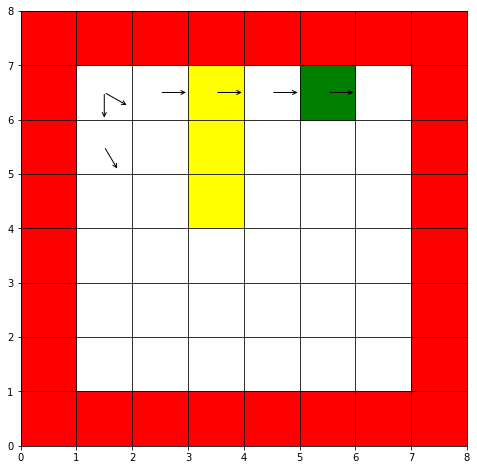

In [0]:
plot_trajectory(policy_start, start_pos, p_e=0)

In [0]:
animate_trajectory(policy_start, start_pos, 0)

In [0]:
value_fn_init = policy_eval(policy_start, 0.9)

In [0]:
print(f'Value at x=1, y=6, h=6, is {value_fn_init[start_pos.index]} from initialization Policy using Policy Evaluation')

Value at x=1, y=6, h=6, is -7.29 from initialization Policy using Policy Evaluation


In [0]:
def Compute_Pmatrix(p_e):
  """Compute the P_sa(s')"""
  Pmatrix = np.zeros([N_states, N_actions, N_states])
  for index1 in range(N_states):
    for a_index, act in enumerate(list_actions):
      for index2 in range(N_states):
        state1 = state(index1)
        state2 = state(index2)
        Pmatrix[index1, a_index, index2] = probability(state1, act,
                                                       state2, p_e)
  return Pmatrix

In [0]:
def Compute_Rvector(reward_fn):
  """Compute R(s, a, s')"""
  R_vector = np.zeros([N_states])
  for index in range(N_states):
    state1 = state(index)
    R_vector[index] = reward_fn(state1)
  return R_vector

In [0]:
Pmatrix = Compute_Pmatrix(0.0)
R_vector = Compute_Rvector(reward)

In [0]:
lam = 0.9

In [0]:
def policy_eval(policy, lam):
  """Evaluate a given Policy"""
  max_delta = 1e-5
  delta = 1
  value_fn = np.zeros([N_states]) # can be init to prev value fn
  while delta > max_delta:
    new_value_fn = np.dot(Pmatrix, R_vector + lam*value_fn)[
          np.arange(N_states), policy]
    delta = np.max(np.abs(new_value_fn - value_fn))
    value_fn = new_value_fn
  return value_fn

In [0]:
def policy_eval_fast(policy, lam, value_fn):
  """Evaluate a given Policy"""
  max_delta = 1e-5
  delta = 1
  # value_fn = np.zeros([N_states]) # can be init to prev value fn
  while delta > max_delta:
    new_value_fn = np.dot(Pmatrix, R_vector + lam*value_fn)[
          np.arange(N_states), policy]
    delta = np.max(np.abs(new_value_fn - value_fn))
    value_fn = new_value_fn
  return value_fn

In [0]:
def policy_improvement(value_fn, lam):
  """Greedy Polciy improvement"""
  return np.argmax(np.dot(Pmatrix, R_vector + lam*value_fn), axis=1)

In [0]:
def policy_iteration(policy):
  """Policy Iteration Algorithm"""
  is_converged = False
  while not is_converged:
    value_fn = policy_eval(policy, lam)
    new_policy = policy_improvement(value_fn, lam)
    if np.all(new_policy == policy):
      is_converged = True
    policy = new_policy
  return policy, value_fn

In [0]:
def policy_iteration_fast(policy):
  """Policy Iteration Algorithm"""
  is_converged = False
  value_fn = np.zeros([N_states]) # can be init to prev value fn
  while not is_converged:
    value_fn = policy_eval_fast(policy, lam, value_fn)
    new_policy = policy_improvement(value_fn, lam)
    if np.all(new_policy == policy):
      is_converged = True
    policy = new_policy
  return policy, value_fn

In [0]:
start_time = timeit.default_timer()
opt_policy_pitr, opt_value_pitr = policy_iteration(policy_start)
duration = timeit.default_timer() - start_time
print(f'Duration: {duration}')

Duration: 3.526094145000002


In [0]:
start_time = timeit.default_timer()
opt_policy_pitr, opt_value_pitr = policy_iteration_fast(policy_start)
duration = timeit.default_timer() - start_time
print(f'Duration: {duration}')

Duration: 1.7311752479999996


x: 1, y: 6, z: 6
x: 1, y: 5, z: 5
x: 1, y: 4, z: 4
x: 2, y: 4, z: 5
x: 2, y: 3, z: 4
x: 3, y: 3, z: 3
x: 4, y: 3, z: 2
x: 5, y: 3, z: 1
x: 5, y: 4, z: 0
x: 5, y: 5, z: 11
x: 5, y: 6, z: 10


(<matplotlib.axes._subplots.AxesSubplot at 0x7f50807f6828>,
 <Figure size 576x576 with 1 Axes>)

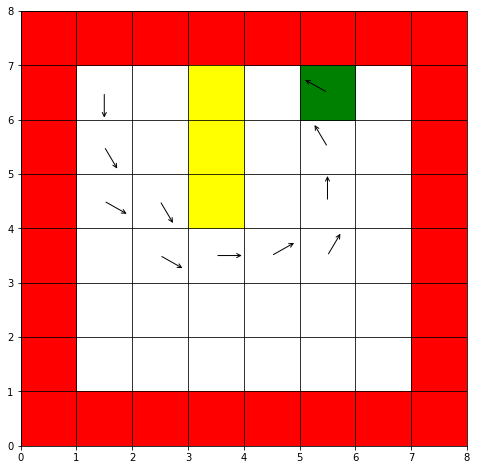

In [0]:
plot_trajectory(opt_policy_pitr, start_pos, p_e=0)

In [0]:
animate_trajectory(opt_policy_pitr, start_pos, 0)

In [0]:
print(f'Value at x=1, y=6, h=6, is {opt_value_pitr[start_pos.index]} based on Policy Iteration')

Value at x=1, y=6, h=6, is 3.874204889999999 based on Policy Iteration


### 4) Value Iteration


In [0]:
def value_iteration():
  value_fn = np.zeros([N_states])
  max_delta = 1e-6
  delta = 1
  while delta > max_delta:
    new_value_fn = np.max(np.dot(Pmatrix, R_vector + lam*value_fn), axis=1)
    delta = np.max(np.abs(new_value_fn - value_fn))
    value_fn = new_value_fn
  policy = np.argmax(np.dot(Pmatrix, R_vector + lam*value_fn), axis=1)
  policy = [action(cur_policy) for cur_policy in policy]
  return policy, value_fn

In [0]:
start_time = timeit.default_timer()
opt_policy_val_itr, opt_value_val_itr = value_iteration()
duration = timeit.default_timer() - start_time
print(f'Duration: {duration}')

Duration: 0.5540915389999554


x: 1, y: 6, z: 6
x: 1, y: 5, z: 5
x: 1, y: 4, z: 4
x: 2, y: 4, z: 5
x: 2, y: 3, z: 4
x: 3, y: 3, z: 3
x: 4, y: 3, z: 2
x: 5, y: 3, z: 1
x: 5, y: 4, z: 0
x: 5, y: 5, z: 11
x: 5, y: 6, z: 10


(<matplotlib.axes._subplots.AxesSubplot at 0x7f50805af278>,
 <Figure size 576x576 with 1 Axes>)

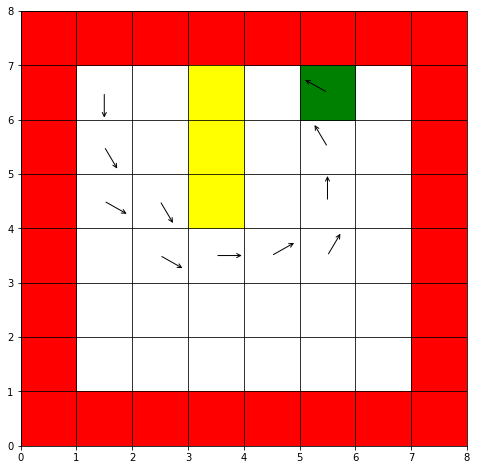

In [0]:
plot_trajectory(opt_policy_val_itr, start_pos, p_e=0)

In [0]:
animate_trajectory(opt_policy_val_itr, start_pos, 0)

In [0]:
print(f'Value at x=1, y=6, h=6, is {opt_value_val_itr[start_pos.index]} based on Value Iteration')

Value at x=1, y=6, h=6, is 3.8741966816898983 based on Value Iteration


### 5) Additional scenarious

##### 5a) 

**If p_e = 0.25, compute the trajactory, value and policy functions.**

In [0]:
Pmatrix = Compute_Pmatrix(0.25)
R_vector = Compute_Rvector(reward)

In [0]:
start_time = timeit.default_timer()
opt_policy_val_itr2, opt_value_val_itr2 = value_iteration()
duration = timeit.default_timer() - start_time
print(f'Duration: {duration}')

Duration: 0.5679019080000671


x: 1, y: 6, z: 6
x: 1, y: 5, z: 5
x: 1, y: 4, z: 6
x: 1, y: 3, z: 4
x: 2, y: 3, z: 3
x: 3, y: 3, z: 2
x: 2, y: 3, z: 3
x: 3, y: 3, z: 4
x: 4, y: 3, z: 3
x: 5, y: 3, z: 4
x: 4, y: 3, z: 4
x: 4, y: 2, z: 6
x: 4, y: 3, z: 7
x: 4, y: 4, z: 6
x: 4, y: 5, z: 7
x: 4, y: 6, z: 6
x: 4, y: 5, z: 7
x: 4, y: 6, z: 5
x: 4, y: 5, z: 5
x: 4, y: 4, z: 6
x: 4, y: 5, z: 7
x: 4, y: 6, z: 5
x: 4, y: 5, z: 4
x: 5, y: 5, z: 5
x: 5, y: 6, z: 5


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5080932198>,
 <Figure size 576x576 with 1 Axes>)

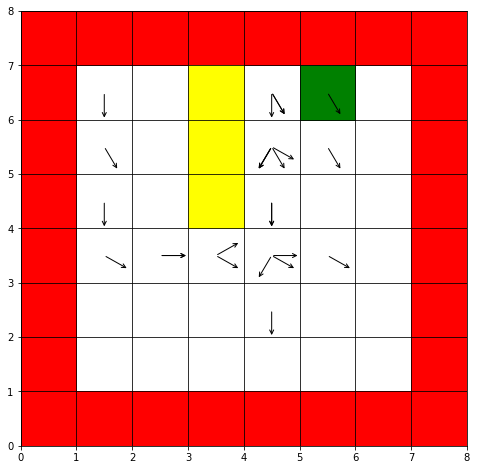

In [0]:
plot_trajectory(opt_policy_val_itr2, start_pos, p_e=0.25)

In [0]:
animate_trajectory(opt_policy_val_itr2, start_pos, p_e=0.25)

In [0]:
print(f'Value at x=1, y=6, h=6, is {opt_value_val_itr2[start_pos.index]} based on Value Iteration')

Value at x=1, y=6, h=6, is 1.8296381910710955 based on Value Iteration


#### 5b)

New reward function

In [0]:
def reward2(s_state):
  """Reward at given state"""
  x, y, h = s_state.s
  L, W = 8, 8
  if x == 0 or x == L-1 or y == 0 or y == W-1: # red cells
    return -100
  elif x == 3 and y >= 4 and y <= 6: # yellow cells
    return -10
  elif x == 5 and y == 6 and h == 6: # green cell
    return 1 # goal
  else: # rest white cells
    return 0

In [0]:
Pmatrix = Compute_Pmatrix(0.25)
R_vector = Compute_Rvector(reward2)

#### p is 0.25

In [0]:
start_time = timeit.default_timer()
opt_policy_val_itr3, opt_value_val_itr3 = value_iteration()
duration = timeit.default_timer() - start_time
print(f"Duration: {duration}")

Duration: 0.5604312699999809


x: 1, y: 6, z: 6
x: 1, y: 5, z: 7
x: 1, y: 6, z: 5
x: 2, y: 6, z: 3
x: 1, y: 6, z: 5
x: 1, y: 5, z: 5
x: 1, y: 4, z: 6
x: 1, y: 3, z: 5
x: 2, y: 3, z: 3
x: 3, y: 3, z: 2
x: 2, y: 3, z: 4
x: 3, y: 3, z: 4
x: 4, y: 3, z: 4
x: 5, y: 3, z: 5
x: 5, y: 4, z: 6
x: 5, y: 5, z: 5
x: 5, y: 6, z: 6


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5080089080>,
 <Figure size 576x576 with 1 Axes>)

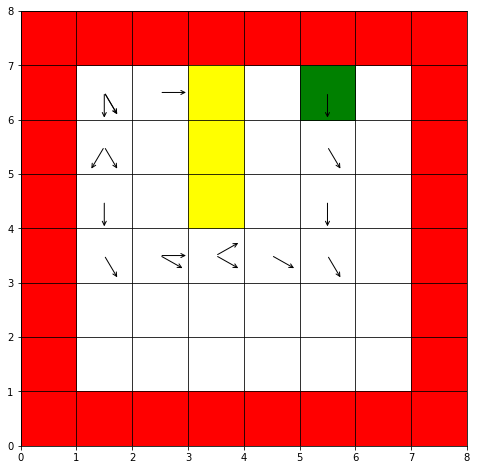

In [0]:
plot_trajectory(opt_policy_val_itr3, start_pos, p_e=0.25)

In [0]:
animate_trajectory(opt_policy_val_itr3, start_pos, p_e=0.25) # every time u get different trajectory as u have random ness in the environment

In [0]:
print(f'Value at x=1, y=6, h=6, is {opt_value_val_itr3[start_pos.index]} based on Value Iteration')

Value at x=1, y=6, h=6, is 1.3318503851782333 based on Value Iteration


#### p is 0.0

In [0]:
Pmatrix = Compute_Pmatrix(0.0)
R_vector = Compute_Rvector(reward2)

In [0]:
start_time = timeit.default_timer()
opt_policy_val_itr4, opt_value_val_itr4 = value_iteration()
duration = timeit.default_timer() - start_time
print(f"Duration: {duration}")

Duration: 0.5847614889999022


x: 1, y: 6, z: 6
x: 1, y: 5, z: 5
x: 1, y: 4, z: 4
x: 2, y: 4, z: 5
x: 2, y: 3, z: 4
x: 3, y: 3, z: 3
x: 4, y: 3, z: 4
x: 5, y: 3, z: 5
x: 5, y: 4, z: 6
x: 5, y: 5, z: 5
x: 5, y: 6, z: 6


(<matplotlib.axes._subplots.AxesSubplot at 0x7f507f9b08d0>,
 <Figure size 576x576 with 1 Axes>)

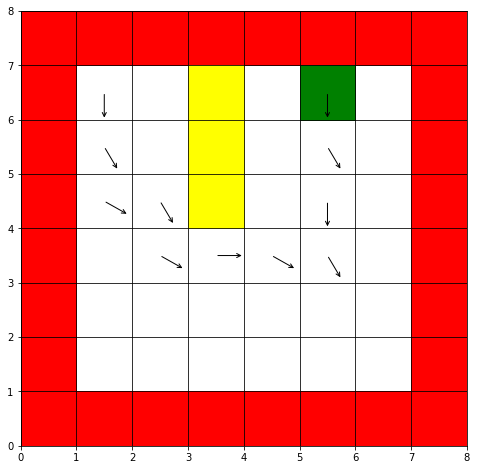

In [0]:
plot_trajectory(opt_policy_val_itr4, start_pos, p_e=0.0)

In [0]:
animate_trajectory(opt_policy_val_itr4, start_pos, p_e=0)

In [0]:
print(f'Value at x=1, y=6, h=6, is {opt_value_val_itr4[start_pos.index]} based on Value Iteration')

Value at x=1, y=6, h=6, is 3.8741966816898983 based on Value Iteration


In [0]:
start_pos.index

594

In [0]:
opt_value_val_itr4[594]

3.8741966816898983

In [0]:
state([5, 5,3]).index

543

In [0]:
opt_value_val_itr4[642]

9.999991791689899

In [0]:
max(opt_value_val_itr)

9.999991791689899

In [0]:
opt_value_val_itr4[543]

8.0999917916899

In [0]:
1/0.1

10.0